# Testing notebook

In [32]:
from src.seq2seq.dataset import SeqDataset, pad_batch
from functools import partial

pad_batch_with_fixed_length = partial(pad_batch, fixed_length=128)
dataset_path = '/home/gkulemeyer/Documents/Repos/AEseq2seq/data/ArchiveII-KFold/common/fold_0_test.csv'
data = SeqDataset( dataset_path, min_len=0, max_len=512, verbose=False, cache_path=None, for_prediction=False,  training=False)

In [33]:
L = [data[i]['length'] for i in range(len(data))]
L.sort()
print(L)

[32, 33, 33, 33, 35, 36, 38, 51, 58, 58, 62, 64, 65, 65, 66, 70, 71, 71, 72, 72, 72, 72, 72, 72, 73, 73, 73, 73, 74, 74, 74, 74, 74, 74, 74, 74, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 78, 78, 78, 78, 78, 78, 79, 79, 80, 81, 82, 82, 82, 84, 85, 85, 85, 85, 85, 86, 86, 86, 87, 87, 87, 88, 88, 88, 88, 89, 89, 90, 90, 90, 90, 91, 91, 91, 91, 92, 92, 92, 92, 93, 94, 96, 96, 96, 98, 98, 98, 98, 98, 98, 98, 98, 98, 99, 99, 99, 100, 100, 100, 101, 101, 101, 101, 101, 101, 101, 101, 102, 102, 102, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 104, 104, 104, 105, 105, 105, 105, 106, 106, 106, 106, 107, 107, 107, 108, 108, 110, 110, 111, 111, 111, 111, 111, 112, 113, 113, 113, 114, 114, 114, 114, 115, 115, 115, 1

In [34]:
for n in range(3):
    print(n,data[n]['length'], data[n]['embedding'].shape)

0 115 torch.Size([4, 115])
1 77 torch.Size([4, 77])
2 103 torch.Size([4, 103])


In [35]:
from torch.utils.data import DataLoader

loader = DataLoader(data, batch_size=1, shuffle=False,collate_fn=pad_batch_with_fixed_length)

next(iter(loader))['embedding'].shape

torch.Size([1, 4, 128])

In [36]:
import torch as tr
x = tr.tensor([[
    [1,0,0,0,1,0,0,0],
    [0,1,0,0,0,1,0,0],
    [0,0,1,0,0,0,1,0],
    [0,0,0,1,0,0,0,1],]
])
x.shape

torch.Size([1, 4, 8])

In [37]:
import pandas as pd
from torch.utils.data import Dataset
import torch as tr
import os
import json
import pickle
import random
from src.seq2seq.embeddings import OneHotEmbedding
from typing import Union

class SeqDataset2(Dataset):
    def __init__(
        self,
        dataset_path,
        min_len=0,
        max_len=512,
        verbose=False,
        cache_path=None,
        for_prediction=False,
        training=False,
        n_swaps=0,
        mode='perc',
        **kargs,
    ):
        """
        interaction_prior: none, probmat
        """
        self.max_len = max_len
        self.verbose = verbose
        if cache_path is not None and not os.path.isdir(cache_path):
            os.mkdir(cache_path)
        self.cache = cache_path

        # Loading dataset
        data = pd.read_csv(dataset_path)
        self.training = training

        assert (
            "sequence" in data.columns and "id" in data.columns
        ), "Dataset should contain 'id' and 'sequence' columns"

        data["len"] = data.sequence.str.len()

        if max_len is None:
            max_len = max(data.len)
        self.max_len = max_len

        datalen = len(data)

        data = data[(data.len >= min_len) & (data.len <= max_len)]

        if len(data) < datalen:
            print(
                f"From {datalen} sequences, filtering {min_len} < len < {max_len} we have {len(data)} sequences"
            )

        self.sequences = data.sequence.tolist()
        self.ids = data.id.tolist()
        self.embedding = OneHotEmbedding()
        self.embedding_size = self.embedding.emb_size
        self.n_swaps = n_swaps
        self.mode = mode

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seqid = self.ids[idx]
        cache = f"{self.cache}/{seqid}.pk"
        if (self.cache is not None) and os.path.isfile(cache):
            item = pickle.load(open(cache, "rb"))
        else:
            sequence = self.sequences[idx]
            L = len(sequence)
            seq_emb = self.embedding.seq2emb(sequence) 
            embedding_with_noise = add_noise(seq_emb.clone(), self.n_swaps, self.mode)

            item = {
                "id": seqid,
                "length": L,
                "sequence": sequence,
                "embedding": seq_emb,
                "embedding_with_noise": embedding_with_noise,
            }

            if self.cache is not None:
                pickle.dump(item, open(cache, "wb"))

        return item


def pad_batch(batch, fixed_length=0):
    """batch is a dictionary with different variables lists"""
    L = [b["length"] for b in batch]
    if fixed_length == 0:
        fixed_length = max(L)
    embedding_pad = tr.zeros((len(batch), batch[0]["embedding"].shape[0], fixed_length))
    embedding_pad_w_noise = tr.zeros(
        (len(batch), batch[0]["embedding_with_noise"].shape[0], fixed_length)
    )
    mask = tr.zeros((len(batch), fixed_length), dtype=tr.bool)

    for k in range(len(batch)):
        embedding_pad[k, :, : L[k]] = batch[k]["embedding"]
        embedding_pad_w_noise[k, :, : L[k]] = batch[k]["embedding_with_noise"]
        mask[k, : L[k]] = 1
    out_batch = {
        "id": [b["id"] for b in batch],
        "length": L,
        "sequence": [b["sequence"] for b in batch],
        "embedding": embedding_pad,
        "embedding_with_noise": embedding_pad_w_noise,
        "mask": mask,
    }

    return out_batch


def add_noise(x: tr.Tensor, swaps: Union[int,float] = 0, mode: str = 'perc') -> tr.Tensor:
    """
    Introduces noise into the tensor `x` by modifying some of its columns with random values.

    Parameters:
    x (torch.Tensor): Input tensor of size (N, len), where N=4 is the number of One-Hot dimension and len is the number of nucleotides.
    swaps (int or float, optional): Number of swaps to perform. Can be:
        - A positive integer, specifying the exact number of swaps.
        - A value between 0 and 1, interpreted as a percentage of the number of columns.
        - 0 (default), meaning no changes are made.
    mode (str, optional): Interpretation mode of `swaps`.
        - 'perc' (default): If `swaps` is 1, all columns are replaced.
        - 'int': `swaps` is treated as an absolute number of swaps.

    Returns:
    torch.Tensor: Modified tensor with added noise.
    """
    len = x.shape[-1]
    if swaps == 0:
        return x
    elif swaps > 0 and swaps < 1: 
        swaps = round(len * swaps)
    elif (mode == 'perc' and swaps == 1) or swaps > len:
        swaps = len
    
    rand_nt = [_ for _ in range(len)]
    random.shuffle(rand_nt)
    v = [0, 1, 2, 3] 
    
    for i in range(swaps): 
        nt = tr.zeros([4], dtype=tr.float)
        random.shuffle(v)
        nt[v[0]] = 1.0
        x[:, rand_nt[i]] = nt
    return x

In [61]:
pad_batch_with_fixed_length = partial(pad_batch, fixed_length=0)
dataset_path = '/home/gkulemeyer/Documents/Repos/AEseq2seq/data/ArchiveII-KFold/common/fold_0_train.csv'
data = SeqDataset2( dataset_path, min_len=0, max_len=512, verbose=False, cache_path=None, for_prediction=False,  training=False, n_swaps=1, mode='perc')
data2 = SeqDataset2( dataset_path, min_len=0, max_len=30, verbose=False, cache_path=None, for_prediction=False,  training=False, n_swaps=30, mode='perc')

From 1528 sequences, filtering 0 < len < 30 we have 3 sequences


In [62]:
L = [data[l]['length'] for l in range(len(data))]
L.sort()
print(L)

[30, 30, 30, 31, 32, 33, 33, 36, 36, 36, 36, 41, 41, 41, 42, 47, 52, 52, 53, 53, 53, 53, 54, 54, 54, 55, 56, 57, 57, 58, 58, 58, 58, 59, 60, 62, 62, 64, 64, 64, 65, 66, 67, 67, 67, 67, 67, 67, 68, 68, 69, 70, 70, 70, 70, 70, 70, 71, 71, 71, 71, 71, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 73, 73, 73, 73, 73, 73, 73, 73, 73, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76,

In [63]:
for n in range(3):
    print(n,data[n]['length'], data[n]['embedding'].shape)

0 119 torch.Size([4, 119])
1 120 torch.Size([4, 120])
2 120 torch.Size([4, 120])


In [64]:
abs((data2[0]['embedding_with_noise'] - data2[0]['embedding'])/2).sum().item()

22.0

In [ ]:
loader = DataLoader(data2, batch_size=1, shuffle=False, collate_fn=pad_batch_with_fixed_length) 
l = next(iter(loader))
l

{'id': ['srp_List.wels._AM263198'],
 'length': [30],
 'sequence': ['AACCAUGUCAGGUCCGGAAGGAAGCAGCAU'],
 'embedding': tensor([[[1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
           1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.],
          [0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1.,
           0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]]),
 'embedding_with_noise': tensor([[[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
           1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
          [1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
           0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],


In [149]:
s = 0
data2 = SeqDataset2( dataset_path, min_len=0, max_len=30, verbose=False, cache_path=None, for_prediction=False,  training=False, n_swaps=15, mode='int')
loader = DataLoader(data2, batch_size=1, shuffle=False, collate_fn=pad_batch_with_fixed_length) 
l = next(iter(loader))
for i in range(30):
    s+= int((l['embedding'][0,:,i] == l['embedding_with_noise'][0,:,i]).sum().item() == 4)
print(s/30)

From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
0.6666666666666666


From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len <

From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len <

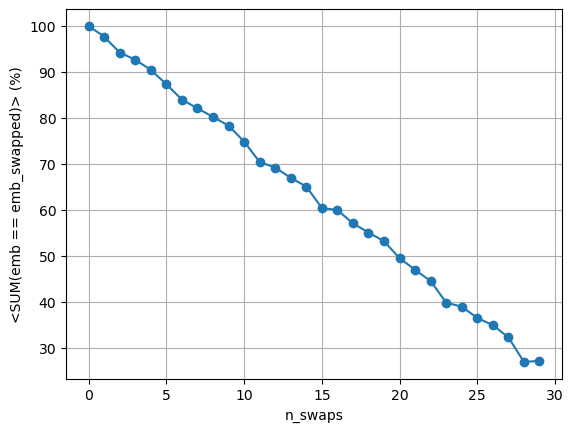

In [ ]:
pswap_30 = []
M = 30
for swaps in range(30):
    pswap_30.append(0.)
    for i in range(M):
        data2 = SeqDataset2( dataset_path, min_len=0, max_len=30, verbose=False, cache_path=None, for_prediction=False,  training=False, n_swaps=swaps, mode='int')
        loader = DataLoader(data2, batch_size=1, shuffle=False, collate_fn=pad_batch_with_fixed_length) 
        l = next(iter(loader))
        for j in range(30):
            pswap_30[swaps] += int((l['embedding'][0,:,j] == l['embedding_with_noise'][0,:,j]).sum().item() == 4)
    pswap_30[swaps] = (pswap_30[swaps] / (M))

import matplotlib.pyplot as plt

plt.plot(list(range(30)), [100 * d/30 for d in pswap_30], marker='o') 
plt.xlabel('n_swaps')
plt.ylabel('<SUM(emb == emb_swapped)> (%)')

plt.grid()

In [179]:
nswap_30 = []
M = 30
for swaps in range(119):
    nswap_30.append(0.)
    for i in range(M):
        data2 = SeqDataset2( dataset_path, min_len=0, max_len=30, verbose=False, cache_path=None, for_prediction=False,  training=False, n_swaps=swaps, mode='int')
        loader = DataLoader(data2, batch_size=1, shuffle=False, collate_fn=pad_batch_with_fixed_length) 
        l = next(iter(loader))
        for j in range(30):
            nswap_30[swaps] += int((l['embedding'][0,:,j] == l['embedding_with_noise'][0,:,j]).sum().item() == 4)
    nswap_30[swaps] = (nswap_30[swaps] / (M))

import matplotlib.pyplot as plt


From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len <

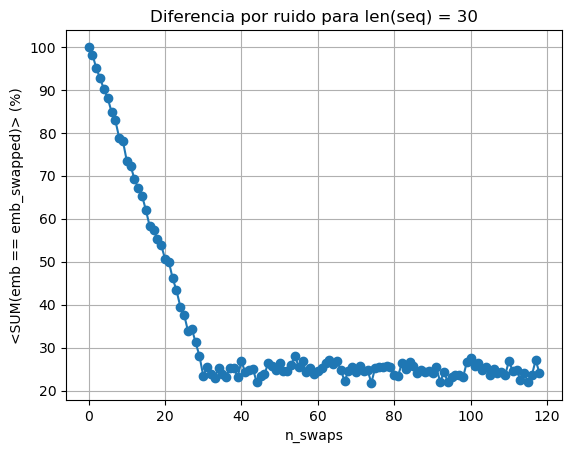

In [180]:

plt.plot(list(range(119)), [100 * d/30 for d in nswap_30], marker='o') 
plt.title('Diferencia por ruido para len(seq) = 30')
plt.xlabel('n_swaps')
plt.ylabel('<SUM(emb == emb_swapped)> (%)')

plt.grid()

From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len <

From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len < 30 we have 3 sequences
From 1528 sequences, filtering 0 < len <

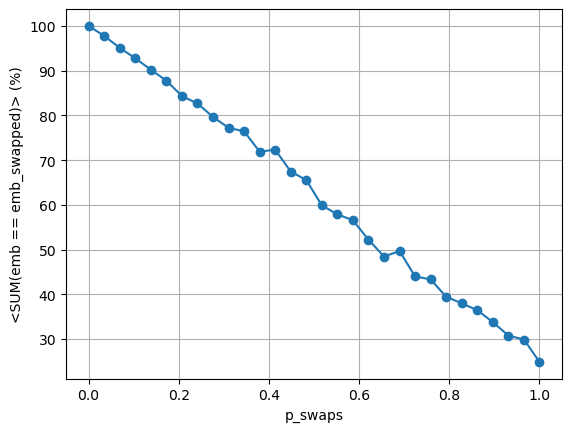

In [181]:
pswap_30 = []
M = 30
x = np.linspace(0,1,30)
for swaps in range(30):
    pswap_30.append(0.)
    for i in range(M):
        data2 = SeqDataset2( dataset_path, min_len=0, max_len=30, verbose=False, cache_path=None, for_prediction=False,  training=False, n_swaps=x[swaps], mode='perc')
        loader = DataLoader(data2, batch_size=1, shuffle=False, collate_fn=pad_batch_with_fixed_length) 
        l = next(iter(loader))
        for j in range(30):
            pswap_30[swaps] += int((l['embedding'][0,:,j] == l['embedding_with_noise'][0,:,j]).sum().item() == 4)
    pswap_30[swaps] = (pswap_30[swaps] / (M))

import matplotlib.pyplot as plt

plt.plot(x, [100 * d/30 for d in pswap_30], marker='o') 
plt.xlabel('p_swaps')
plt.ylabel('<SUM(emb == emb_swapped)> (%)')

plt.grid()

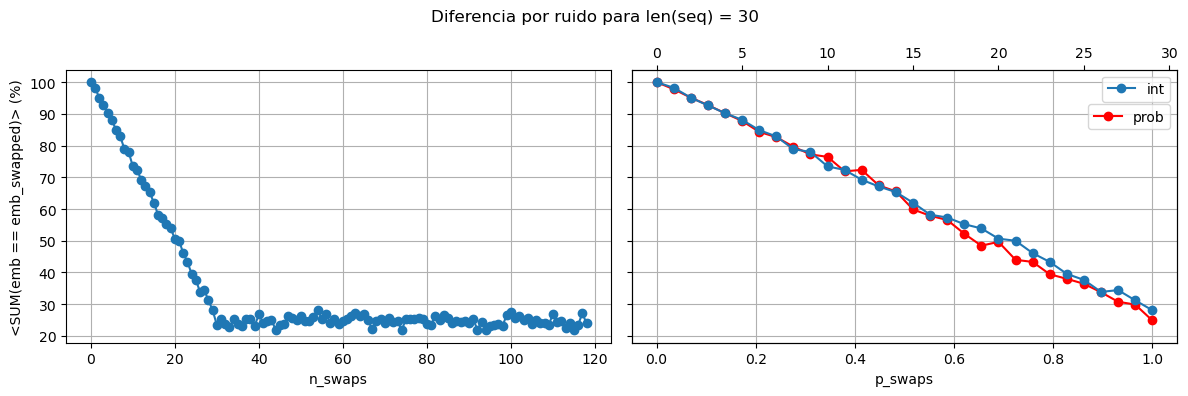

In [204]:
fig, ax  = plt.subplots(1,2, figsize=(12,4),sharey=True)

ax[0].plot(list(range(119)), [100 * d/30 for d in nswap_30], marker='o') 
fig.suptitle('Diferencia por ruido para len(seq) = 30')
ax[0].set_xlabel('n_swaps')
ax[0].set_ylabel('<SUM(emb == emb_swapped)> (%)')
ax[1].set_xlabel('p_swaps')
ax[1].plot(x, [100 * d/30 for d in pswap_30], marker='o', label='prob', color='red') 
a_ = ax[1].twiny()
a_.plot(list(range(30)), [100 * d/30 for d in nswap_30][:30], marker='o', label='int') 
a_.legend()
ax[1].legend(bbox_to_anchor=(1,0.9))
for a in ax: a.grid()
fig.tight_layout()

In [162]:

data2 = SeqDataset2( dataset_path, min_len=0, max_len=512, verbose=False, cache_path=None, for_prediction=False,  training=False, n_swaps=swaps, mode='int')
loader = DataLoader(data2, batch_size=1, shuffle=False, collate_fn=pad_batch_with_fixed_length) 
l = next(iter(loader))
l['length']

[119]

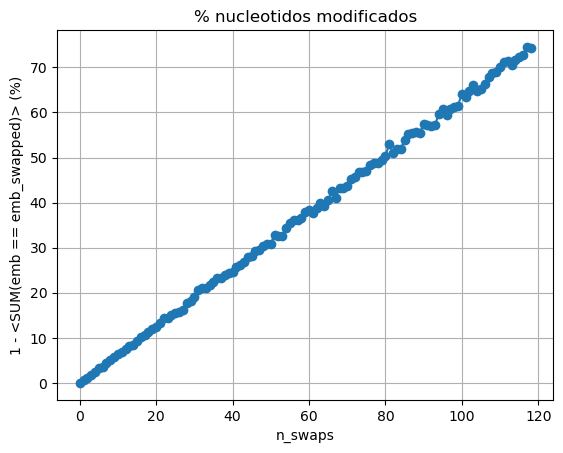

In [205]:
swap_119 = []
M = 30
for swaps in range(119):
    swap_119.append(0.)
    for i in range(M):
        data2 = SeqDataset2( dataset_path, min_len=0, max_len=512, verbose=False, cache_path=None, for_prediction=False,  training=False, n_swaps=swaps, mode='int')
        loader = DataLoader(data2, batch_size=1, shuffle=False, collate_fn=pad_batch_with_fixed_length) 
        l = next(iter(loader))
        for j in range(119):
            swap_119[swaps] += int((l['embedding'][0,:,j] == l['embedding_with_noise'][0,:,j]).sum().item() == 4)
    swap_119[swaps] = (swap_119[swaps] / (M))

import matplotlib.pyplot as plt

plt.plot(list(range(119)), [100 - 100 * d/119 for d in swap_119], marker='o') 
plt.title('% nucleotidos modificados')
plt.xlabel('n_swaps')
plt.ylabel('1 - <SUM(emb == emb_swapped)> (%)')

plt.grid()

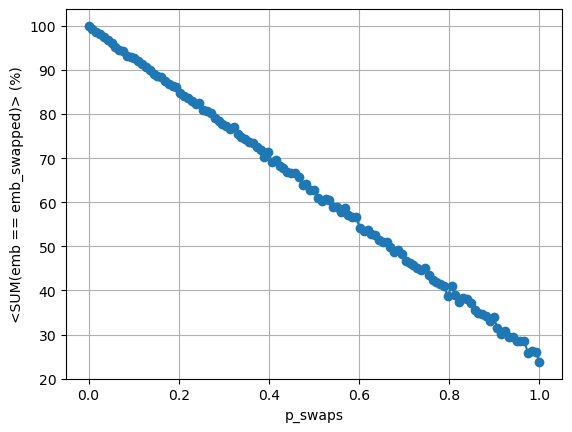

In [206]:
import numpy as np
pswap_119 = []
M = 30
x = np.linspace(0,1,119)
for swaps in range(119):
    pswap_119.append(0.)
    for i in range(M):
        data2 = SeqDataset2( dataset_path, min_len=0, max_len=512, verbose=False, cache_path=None, for_prediction=False,  training=False, n_swaps=x[swaps], mode='perc')
        loader = DataLoader(data2, batch_size=1, shuffle=False, collate_fn=pad_batch_with_fixed_length) 
        l = next(iter(loader))
        for j in range(119):
            pswap_119[swaps] += int((l['embedding'][0,:,j] == l['embedding_with_noise'][0,:,j]).sum().item() == 4)
    pswap_119[swaps] = (pswap_119[swaps] / (M))

import matplotlib.pyplot as plt

plt.plot(x, [100 * d/119 for d in pswap_119], marker='o') 
plt.xlabel('p_swaps')
plt.ylabel('<SUM(emb == emb_swapped)> (%)')

plt.grid()

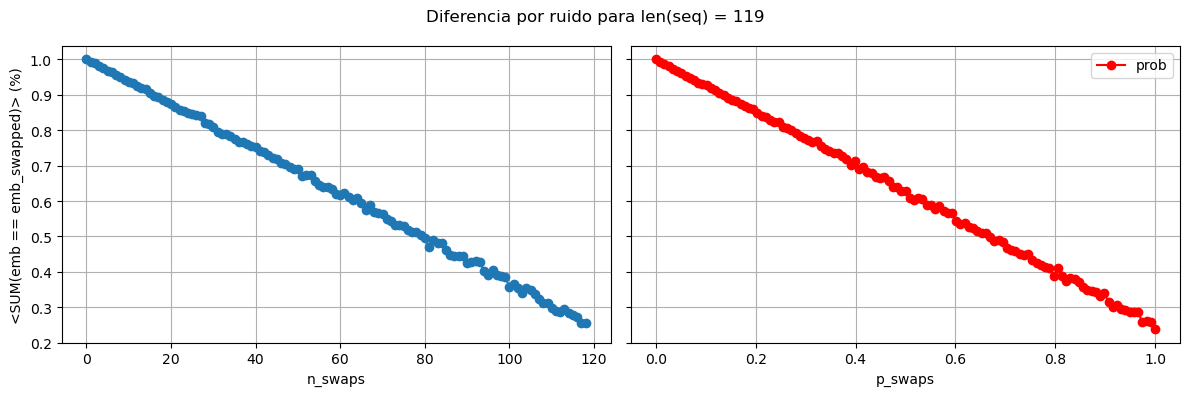

In [211]:
fig, ax  = plt.subplots(1,2, figsize=(12,4),sharey=True)

ax[0].plot(list(range(119)),[d/119 for d in swap_119], marker='o') 
fig.suptitle('Diferencia por ruido para len(seq) = 119')
ax[0].set_xlabel('n_swaps')
ax[0].set_ylabel('<SUM(emb == emb_swapped)> (%)')
ax[1].set_xlabel('p_swaps')
ax[1].plot(x, [d/119 for d in pswap_119], marker='o', label='prob', color='red')  
ax[1].legend()
for a in ax: a.grid()
fig.tight_layout()